<a href="https://colab.research.google.com/github/iris9112/csv_python/blob/master/Twitter_con_K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementando k-means 

Ejercicio para agrupar usuarios de twitter de acuerdo a su personaliad, usando el algoritmo k-means y la libreria sklearn.

Este notebook contiene el ejercicio del tutorial [Un ejemplo K-Means en Python con Sklearn](http://www.aprendemachinelearning.com/k-means-en-python-paso-a-paso/).

El archivo csv es un conjunto de datos de usuarios de twitter con diferentes medidas de los rasgos de la personalidad. Contiene información de 140 “famosos” del mundo en diferentes areas: deporte, cantantes, actores, etc. 

Basado en una metodología de psicología conocida como “Ocean: The Big Five” tendemos como características de entrada:

- usuario (el nombre en Twitter)
- “op” = Openness to experience – grado de apertura mental a nuevas experiencias, curiosidad, arte
- “co” =Conscientiousness – grado de orden, prolijidad, organización
- “ex” = Extraversion – grado de timidez, solitario o participación ante el grupo social
- “ag” = Agreeableness – grado de empatía con los demás, temperamento
- “ne” = Neuroticism, – grado de neuroticismo, nervioso, irritabilidad, seguridad en sí mismo.
- Wordcount – Cantidad promedio de palabras usadas en sus tweets
- Categoria – Actividad laboral del usuario (actor, cantante, etc.)

Utilizaremos el algoritmo K-means para que agrupe estos usuarios -no por su actividad laboral- si no, por sus similitudes en la personalidad.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

In [0]:
file = 'http://www.aprendemachinelearning.com/wp-content/uploads/2018/03/analisis.csv'

In [42]:
df = pd.read_csv(file)
df.head()

,usuario,op,co,ex,ag,ne,wordcount,categoria
0,3gerardpique,34.297953,28.148819,41.948819,29.370315,9.841575,37.0945,7
1,aguerosergiokun,44.986842,20.525865,37.938947,24.279098,10.362406,78.7970,7
2,albertochicote,41.733854,13.745417,38.999896,34.645521,8.836979,49.2604,4
3,AlejandroSanz,40.377154,15.377462,52.337538,31.082154,5.032231,80.4538,2
4,alfredocasero1,36.664677,19.642258,48.530806,31.138871,7.305968,47.0645,4


In [43]:
df.describe()

,op,co,ex,ag,ne,wordcount,categoria
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,44.414591,22.977135,40.764428,22.918528,8.000098,98.715484,4.050000
std,8.425723,5.816851,7.185246,7.657122,3.039248,44.714071,2.658839
min,30.020465,7.852756,18.693542,9.305985,1.030213,5.020800,1.000000
25%,38.206484,19.740299,36.095722,17.050993,6.086144,66.218475,2.000000
50%,44.507091,22.466718,41.457492,21.384554,7.839722,94.711400,3.500000
75%,49.365923,26.091606,45.197769,28.678867,9.758189,119.707925,7.000000
max,71.696129,49.637863,59.824844,40.583162,23.978462,217.183200,9.000000


El archivo contiene diferenciadas 9 categorías (actividades laborales) que son:

1. Actor/actriz
2. Cantante
3. Modelo
4. Tv, series
5. Radio
6. Tecnología
7. Deportes
8. Politica
9. Escritor


In [44]:
# saber cuantos registros tenemos por categoria

df.groupby('categoria').size()

categoria
1    27
2    34
3     9
4    19
5     4
6     8
7    17
8    16
9     6
dtype: int64

Veremos graficamente nuestros datos para tener una idea de la dispersión de los mismos:

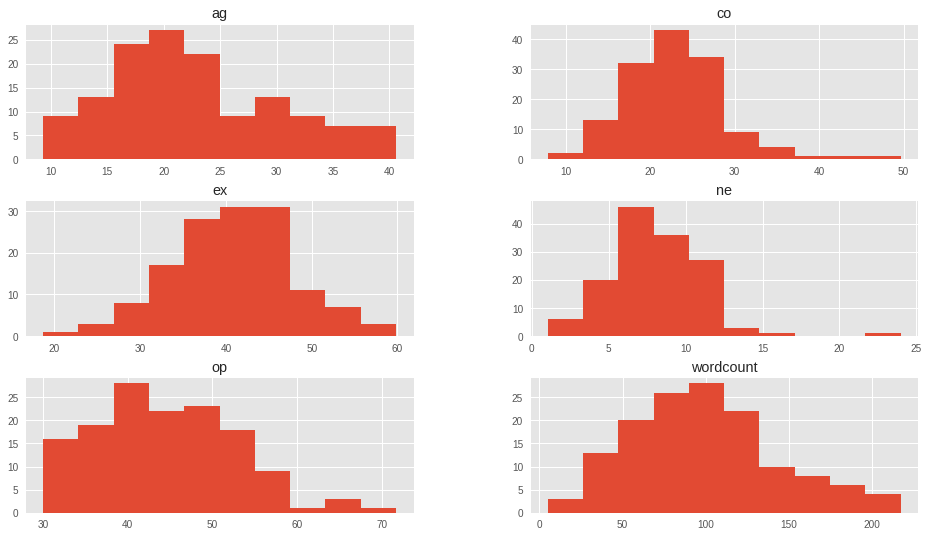

In [45]:
df.drop(['categoria'], 1).hist()
plt.show()

En este caso seleccionamos 3 dimensiones: *op*, *ex* y *ag* y las cruzamos para ver si nos dan alguna pista de su agrupación y la relación con sus categorías:

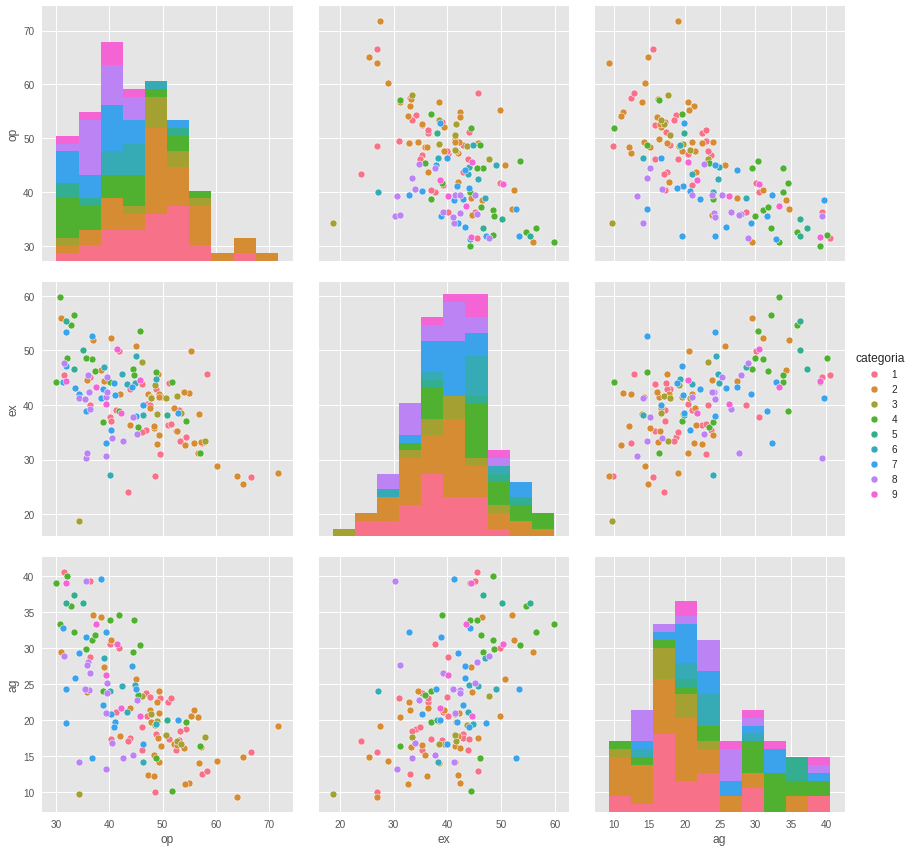

In [46]:
sb.pairplot(df.dropna(), hue='categoria', size=4, vars=['op', 'ex', 'ag'], kind='scatter')

De acuerdo a las gráficas, no parece haber relación entre los usuarios y sus categorías.

Vamos a definir las entradas con las características: op, ex y ag en nuetro eje x, con respecto a la categoría en nuestro eje y.

In [47]:
X = np.array(df[['op', 'ex', 'ag']])
y = np.array(df['categoria'])

# verificando dimensión
X.shape

(140, 3)

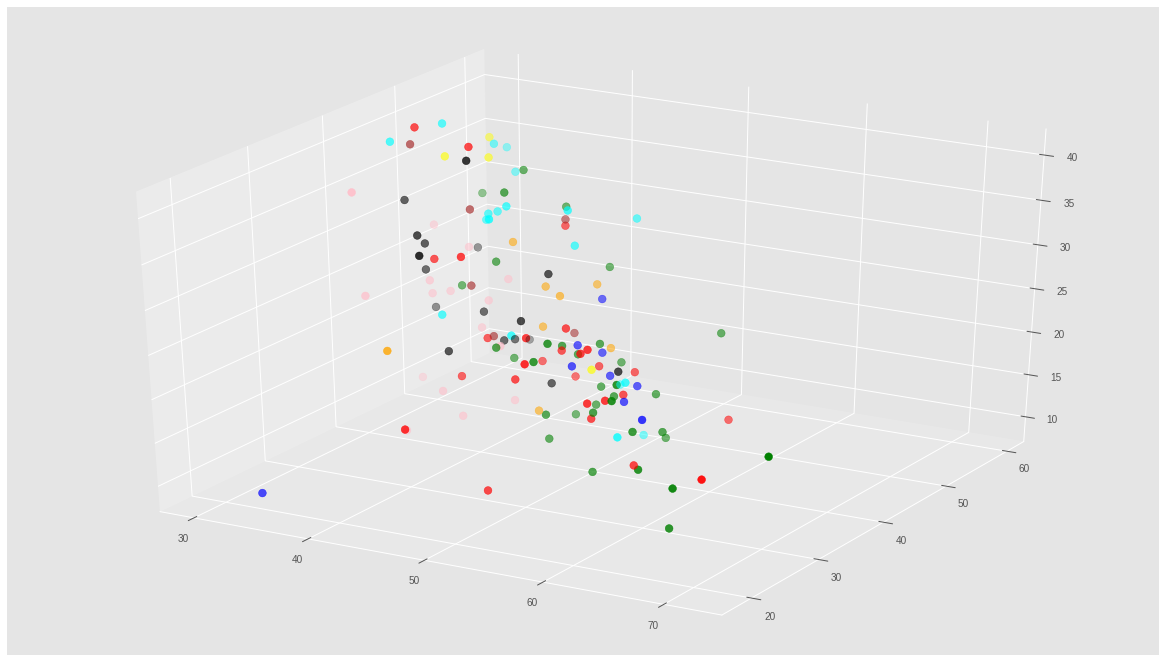

In [48]:
# grafica en 3d reprsentando las 9 categorias

fig = plt.figure()
ax = Axes3D(fig)
colores=['blue','red','green','blue','cyan','yellow','orange','black','pink',
         'brown','purple']

asignar = []

for row in y:
  asignar.append(colores[row])

# seleccionar columnas y graficar
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)

# Creando clusterigns con k-means

Veremos si con K-means, podemos “pintar” esta misma gráfica de otra manera, con clusters diferenciados.

## Obtener el valor K

Vamos a hallar el valor de K haciendo una gráfica e intentando hallar el “punto de codo” 

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max

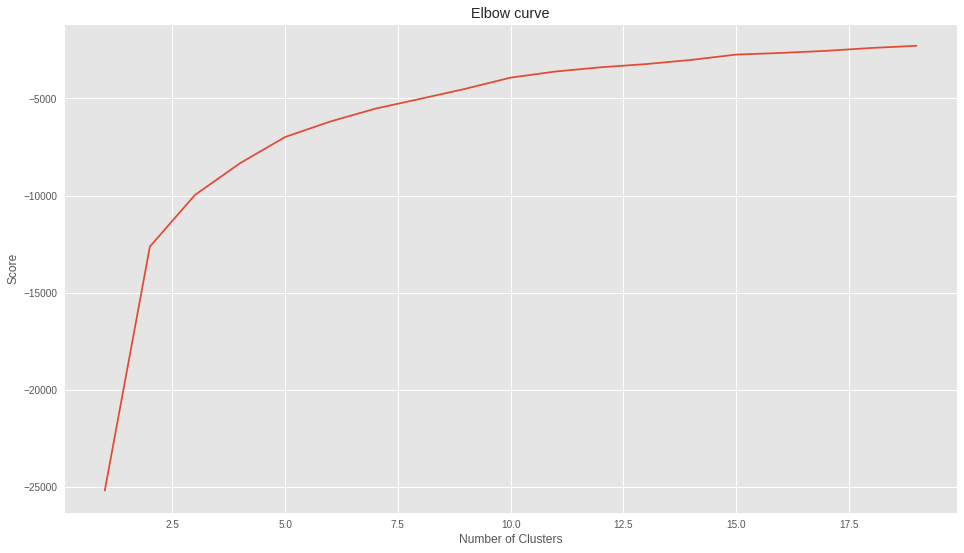

In [51]:
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
print(kmeans)

score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
print(score)

plt.plot(Nc, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow curve')
plt.show()

In [52]:
# 5 parece un buen numero para k

kmeans = KMeans(n_clusters=5).fit(X)

centroids = kmeans.cluster_centers_
print(centroids)

[[50.42588653 40.66723528 17.30892462]
 [35.90241306 47.56828232 33.58748762]
 [40.10497084 43.34066891 23.14697356]
 [58.70462307 30.53566167 15.72207033]
 [42.968253   32.53013537 20.93305995]]


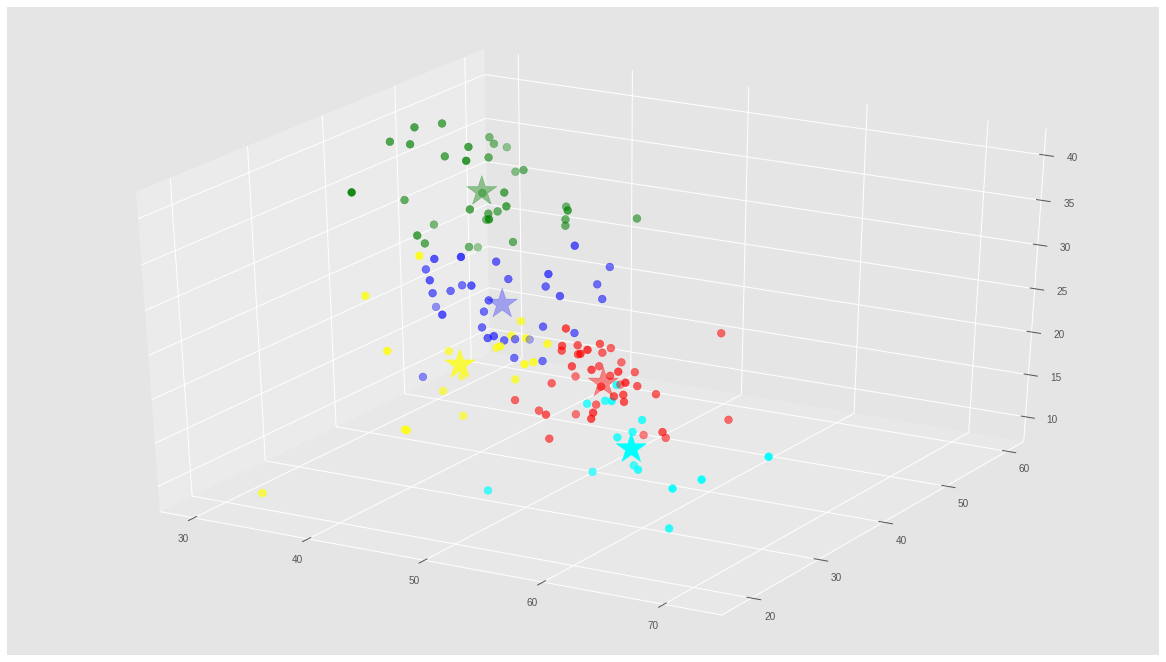

In [53]:
# vamos a graficar los cluster y ver si se diferencian

# predicciones
labels = kmeans.predict(X)

# calculando el cluster central
C = kmeans.cluster_centers_
colores = ['red','green','blue','cyan','yellow']
asignar = []

for row in labels:
  asignar.append(colores[row])
  
fig = plt.figure()
ax = Axes3D(fig)
# pintar clusters
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar, s=60)

# marcar centroide
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

Aqui podemos ver que el Algoritmo de K-Means con K=5 ha agrupado a los 140 usuarios Twitter por su personalidad, teniendo en cuenta las 3 dimensiones que utilizamos: Openess, Extraversion y Agreeablenes. Pareciera que no hay necesariamente una relación en los grupos con sus actividades de Celebrity.

Haremos 3 gráficas en 2 dimensiones con las proyecciones a partir de nuestra gráfica 3D para que nos ayude a visualizar los grupos y su clasificación


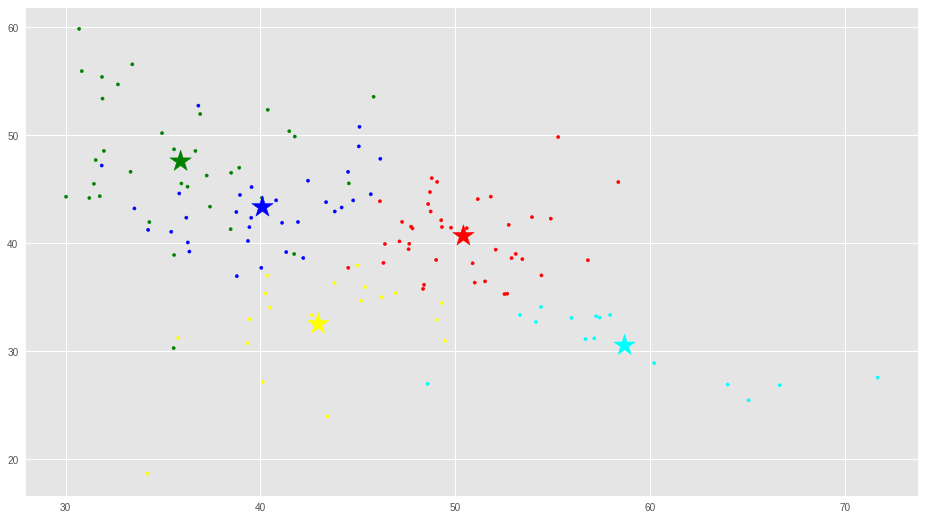

In [54]:
# mostrando 3 graficas en 2D

f1 = df['op'].values
f2 = df['ex'].values

plt.scatter(f1, f2, c=asignar, s=10)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=500)
plt.show()

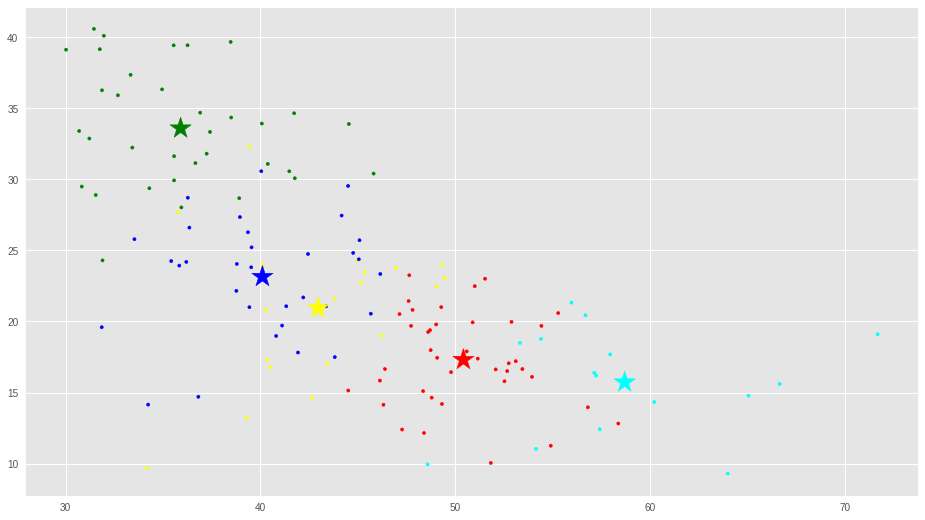

In [55]:
# mostrando 3 graficas en 2D

f1 = df['op'].values
f2 = df['ag'].values

plt.scatter(f1, f2, c=asignar, s=10)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=500)
plt.show()

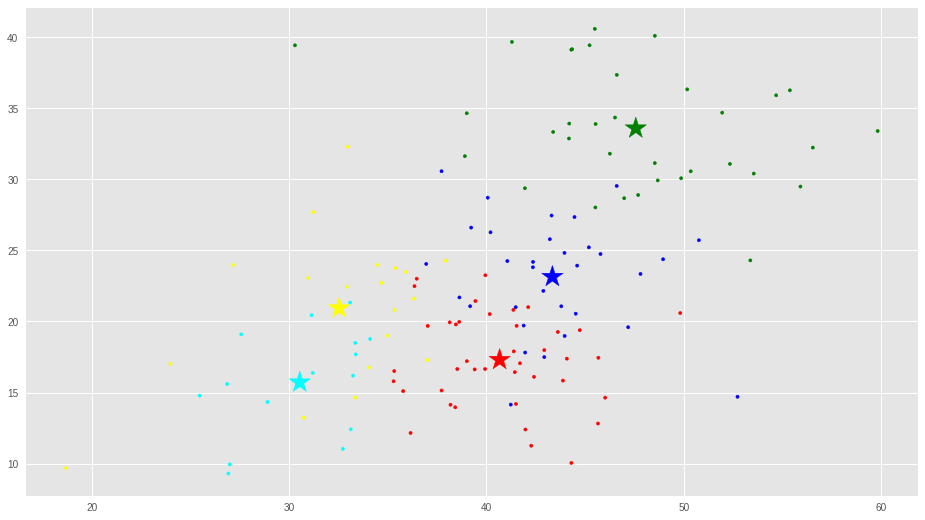

In [56]:
# mostrando 3 graficas en 2D

f1 = df['ex'].values
f2 = df['ag'].values

plt.scatter(f1, f2, c=asignar, s=10)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=500)
plt.show()

In [57]:
# calculando cada cluster cuandos usuarios tiene
	
copy = pd.DataFrame()

copy['usuario'] = df['usuario'].values
copy['categoria'] = df['categoria'].values
copy['label'] = labels;

cantidadGrupo = pd.DataFrame()
cantidadGrupo['color'] = colores
cantidadGrupo['cantidad'] = copy.groupby('label').size()
print(cantidadGrupo)

    color  cantidad
0     red        40
1   green        34
2    blue        32
3    cyan        15
4  yellow        19


In [60]:
# explorando los clusters
copy.sample(15)

,usuario,categoria,label
39,Diane_Keaton,1,4
27,charliesheen,1,2
69,JesusCalleja,4,1
70,JesusEncinar,6,2
102,MileyCyrus,1,0
135,XabiAlonso,7,1
46,epunset,6,0
60,HillaryClinton,8,4
93,LennyKravitz,2,0
65,iescolar,9,2


In [65]:
group_red_index = (copy['label'] == 0)
group_red = copy[group_red_index]
print(group_red.head())
 

            usuario  categoria  label
8       andyroddick          7      0
10  AngelAlessandra          3      0
13     AvrilLavigne          2      0
15       BarRefaeli          3      0
18    britneyspears          2      0


In [81]:
# crear df vacion
diversidad_red = pd.DataFrame()

# crear una primera columna
diversidad_red['categoria'] = ['actor', 'cantante', 'modelo', 'tv', 'radio', 
                               'tecnologia', 'deportes', 'politica', 'Escritor']

# crear columna de conteo
diversidad_red['cantidad'] = group_red.groupby('categoria').size()

print(diversidad_red)

    categoria  cantidad
0       actor       NaN
1    cantante      10.0
2      modelo      15.0
3          tv       6.0
4       radio       3.0
5  tecnologia       1.0
6    deportes       2.0
7    politica       2.0
8    Escritor       1.0


In [88]:
#vemos el representante del grupo, el usuario cercano a su centroid

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)

# array de usuarios
print(closest)

users = df['usuario'].values
for row in closest:
    print(users[row])

[ 21  98  64  82 120]
carmenelectra
maria_patino
ierrejon
JudgeJudy
SarahPalinUSA


In [89]:
# clasificar nuevas muestras


# davidguetta
X_new = np.array([[45.92,57.74,15.66]])
 
new_labels = kmeans.predict(X_new)
print(new_labels)

[2]
